# Modelo de condensación en película adaptado para la condensación de gases de pirólisis 


<p style='text-align: justify;'> Este modelo se basa en el de Herranz et al (1998),el cual tiene en cuenta la presencia de gases no condensables, modificado para convección forzada.  Se tienen en cuenta las resistencias de calor tanto de la película de líquido como de la mezcla de gases, para calcular el flux de calor de la mezcla de gases a la superficie, similar al método Colburn-Hougen  </p>


<p style='text-align: justify;'> Inicialmente, determinamos las temperaturas para la superficie de condensación y para los gases. También calculamos las propiedades  de la mezcla gaseosa y del condensado a las condiciones de presión y temperatura deseadas, mediante la librería de cálculo de propiedades termodinámicas <a href="https://pypi.org/project/thermo/"> <strong><i>Thermo</i></strong></a>  para python. Para ello seleccionamos un conjunto de compuestos representativos que reflejen la fracción de los gases que se desea condensar. En este caso, como componentes de la muestra gaseosa correspondiente a la fracción liviana  del bioaceite seleccionamos:
 </p>

- Nitrógeno (Gas para la atmósfera de pirólisis)
- Agua
- Ácido acético
- Etanol
- Acetaldehido
- Ácido propiónico
- Butanona
- Acetol

Se asume que el bioaceite condensador tiene estos compuestos por partes iguales.


In [1]:
from thermo.chemical import Mixture, Chemical
import statistics
import numpy as np
import math
from IPython.display import Image
from difusion import difusion

T_w=273.15+0 # Temperatura de pared en [K]
T_g=399 # Temperatura de los gases [K]
T_i=273.15+0.05# Temperatura estimada de la interfase en [K] 

T_propiedades= T_w+(0.25*(T_i-T_w))
P=101325 # Presión de operación en pascales


d_ti= 0.07792 # diametro interno del tubo 3" [m]
Z=2.5 # Longitud del tubo[m]
#n= 0.03 # separación entre placas [m]

Frac_n2=0.567 #fracción másica de nitrógeno en los gases de pirólisis
frac_w_g = (1-Frac_n2)*0.2 # Se asume que 20% del bioaceite es agua.
frac_w_c = 0.2 #
frac_comp=(1-Frac_n2-frac_w_g)/6 # Fracción másica de los compuestos en los gases de pirólisis (teniendo en cuenta el N2)
frac_non=(1-0.2)/6 # Fracción másica de los compuestos en el condensado (se asumen partes iguales)

In [2]:

#Composición de los gases de pirólisis
comp = {'Nitrogen': Frac_n2,
        'water': frac_w_g,
        'acetic acid': frac_comp,
        'ethanol': frac_comp,
        'acetaldehyde': frac_comp,
        'propionic acid': frac_comp,
        'butanone': frac_comp,
        'acetol':frac_comp }

#Composición del condensado
compcond = {'water': frac_w_c,
            'acetic acid': frac_non,
            'ethanol': frac_non,
            'acetaldehyde': frac_non,
            'propionic acid': frac_non,
            'butanone': frac_non,
            'acetol': frac_non}

# Declaración de las mezclas para cálculo de propiedades. 
condensado= Mixture(ws=compcond, T=T_propiedades, P=P)# Mezcla del condensado
mezcla_grashof=Mixture(ws=comp, T=T_i, P=P) # Mezcla de gases de pirólisis para calcular grashof en interfase

#Verifica el mínimo punto de ebullición, condicionando la salida de los gases a ser 10 °C menor
T_boil=min([x for x in condensado.Tbs if x is not None]) 
T_sal=T_boil-10


gases = Mixture(ws=comp, T=(T_g+T_sal)/2, P=P)# Mezcla para el cálculo de propiedades de los gases

# Los ciclos for son para descartar valores NA en algunas propiedades para algunos compuestos
den_gases= gases.rhog# densidad de la mezcla gaseosa [Kg/m³]
den_int=mezcla_grashof.rhog # densidad en la interfase
den_cond= condensado.rhol# densidad de la mezcla líquida [kg/m³]
k_gas= gases.kg #conductividad térmica [W/m K]
k_cond= condensado.kl 
visc_gases= statistics.mean([x for x in gases.mugs if x is not None])  # Viscosidad [kg/ms]
visc_cond= statistics.mean([x for x in condensado.muls if x is not None])
cp_gases=gases.Cpg # Capacidad calorífica [J/kg/K]
cp_cond=condensado.Cpl
Pr_gas=statistics.mean([x for x in gases.Prgs if x is not None]) # Número de Prandtl
Pr_cond=statistics.mean([x for x in condensado.Prls if x is not None])

h_fg_prom=statistics.mean([x for x in condensado.Hvaps if x is not None]) # Hvaps es entalpía de evaporación en [J/kg]

C_con=mezcla_grashof.rhogm/den_int# concentración molar en la interfase [mol/Kg]
C_con_bulk=gases.rhogm/gases.rhog #concentración molar en el bulk [mol/kg]

# Concentración molar del nitrógeno en los gases [mol/kg]
C_con_N2=Chemical('Nitrogen', T=(T_propiedades)).rhogm/Chemical('Nitrogen', T=T_propiedades).rho
C_con_N2_bulk=Chemical('Nitrogen', T=(T_g-T_sal/2)).rhogm/Chemical('Nitrogen', T=(T_g-T_sal/2)).rho #mol/kg

print("Densidad condensado: {} kg/m³".format(round(den_cond,4)),
      "Densidad gas: {} kg/m³".format(round(den_gases,4)),
      "Densidad interfase: {} kg/m³".format(round(den_int,4)),
      "Calor de vaporizacion promedio: {} J/kg".format(round(h_fg_prom,4)),
      "Viscosidad gases: {} kg/ms".format(round(visc_gases,8)),
      "Viscosidad condensado: {} kg/ms".format(round(visc_cond,8)),
      "Cp gases: {} J/kg/K".format(round(cp_gases,4)),
      "Cp condensado: {} J/kg/K".format(round(cp_cond,4)),
      "Temperatura de ebullición promedio : {} K".format(T_boil),
      "Conductividad térmica del condensado: {} W/mK".format(round(k_cond,4)),
      "Conductividad térmica del gas: {} W/mK".format(round(k_gas,4)),
      "Prandtl gas: {}".format(round(Pr_gas,2)),   
      "Prandtl líquido: {}".format(round(Pr_cond,2)),  
      "Peso molar gases pirolisis:{} mol/kg".format(round(C_con,2)),
      "Peso molar Nitrógeno:{} mol/kg".format(round(C_con_N2,2)),
      "T salida: {} K".format(round(T_sal,2)),
      sep='\n')


Densidad condensado: 926.2715 kg/m³
Densidad gas: 1.1583 kg/m³
Densidad interfase: 1.4533 kg/m³
Calor de vaporizacion promedio: 890521.3606 J/kg
Viscosidad gases: 1.075e-05 kg/ms
Viscosidad condensado: 0.00121141 kg/ms
Cp gases: 1219.8934 J/kg/K
Cp condensado: 2259.4722 J/kg/K
Temperatura de ebullición promedio : 293.95 K
Conductividad térmica del condensado: 0.1801 W/mK
Conductividad térmica del gas: 0.024 W/mK
Prandtl gas: 0.89
Prandtl líquido: 12.41
Peso molar gases pirolisis:30.93 mol/kg
Peso molar Nitrógeno:35.7 mol/kg
T salida: 283.95 K


### Parámetros de diseño

Para el cálculo del intercambiador se asumirá un intercambiador cilíndrico, para el cual se estima un área transversal que se requiere en los cálculos de velocidades y turbulencia. 

Como parámetros de diseño se tienen los valores del reactor de lecho fluidizado ubicado en el laboratorio de ciencias de la energía:

- Temperatura de entrada de los gases al condensador: 550 °C
- Temperatura de salida de los gases del condensador: 10 °C por debajo del compuesto con menor temperatura de ebullición (aprox 150 °C)
- Flujo de $N_2$: 80 LPM
- Alimentación de biomasa: 2 Kg/h

Como aproximación se asume que el 50% wt de la biomasa se convierte en bioaceite, y que un 10% se convierte en char. El resto son gases permanentes. Con esta información se hace el cálculo de la carga térmica y de la fracción másica de no condensables.


In [3]:
A_i=((d_ti/2)**2)*math.pi # área del ducto por donde pasan los gases [m²]
Lc = d_ti # Longitud característica del tubo

g = 9.81 # aceleración gravitacional [m/s²]

#Flujo de gases

Flujo_N2=(80/1000)/60 # Flujo de diseño del reactor [m³/s]
den_N2= Chemical('nitrogen', T=298.15).rho # Densidad del N2 a las condiciones promedio [Kg/m3]

Cp_N2= Chemical('nitrogen', T=(T_g+T_sal)/2).Cp #Capacidad calorifica del N2 [J/KgK]

mas_N2=Flujo_N2*den_N2 #Flujo másico de N2 [Kg/s]
masa_total = ((mas_N2*3600) + 2)*1000  # Masa que entra al reactor [g/h] 

qs_N2=mas_N2*Cp_N2*(T_g-T_sal) #Calor a extraer del nitrógeno [J/s]


# Carga Térmica Gases Pirólisis

m_biomasa=2/3600# Biomasa que entra al reactor [Kg/s]
m_cond=m_biomasa*0.5*0.8 # Masa del condensado, se calcula para 50% de yield de bioaceite [Kg/s]
                         # Se asume el 80 % de condensado en masa para esta etapa
vol_gasesp= m_biomasa*0.9/den_gases # Volumen de gases de pirólisis, asumiendo 10% de formación de char [m³/s]
vpm3h=vol_gasesp*3600+Flujo_N2*3600 # Volumen de gases en [m³/h]

fraccion_masicaNc=mas_N2/(m_biomasa+mas_N2) # Fracción másica de no condensables 
conc_b=m_cond/(vol_gasesp+Flujo_N2) # Concentración de gases condensables en los gases de pirólisis [Kg/m³]
 
qs_biomasa=m_biomasa*cp_cond*(T_g-T_sal) # Calor sensible que se debe remover de la biomasa [W]
qvap_biomasa=m_cond*h_fg_prom # Calor latente que se debe remover de la biomasa [W]

Q_req=(qs_N2+qs_biomasa+qvap_biomasa)# Calor que se debe remover por cada tubo [W]


vel_gas=((vol_gasesp+Flujo_N2))/A_i# velocidad del gas en los tubos [m/s]


re_l=(m_cond*4)/(math.pi*Z*visc_cond) # Reynolds de la película de condensado Tomado de Cengel (10-8)
                                           # Dividido por el número de tubos
#re_g=(vel_gas*den_gases*Lc)/visc_gases # Reynolds de la corriente gaseosa

re_g = 4*((masa_total/1000)/3600)/(visc_gases*Lc*math.pi)

Gr=(g*(1/T_propiedades)*(T_g-T_w)*(Lc**3))/(visc_gases/den_gases)# Numero de grashof


moles_cond=m_cond*C_con # Flujo molar de condensado en la interfase?[mol/s]
moles_N2=mas_N2*C_con_N2 # Flujo molar de N2 [mol/s]
moles_cond_bulk=m_cond*C_con_bulk # Flujo molar de condensado en el bulk [mol/s]
moles_N2_bulk=mas_N2*C_con_N2_bulk # Flujo molar de condensado en el bulk [mol/s]



    
print("Reynolds de la mezcla gaseosa: {}".format(round(re_g,2)),
      "Reynolds del líquido: {}".format(round(re_l,2)),
      "Longitud característica: {}".format(round(Lc,2)),

      "Carga térmica total: {} kW".format(round(Q_req/1000,3)),
      "Carga térmica por tubo: {} kW".format(round(Q_req/1000,3)),
      "Velocidad de gases en el intercambiador: {} m/s".format(round(vel_gas,3)),
     
     "Grashof mezcla gaseosa: {}".format(round(Gr,5)),
     "Flujo gases hora: {} m³/h".format(round(vpm3h,5)),
     "Masa condensado: {} kg/h".format(round(m_cond*3600,5)),
      "Masa total: {} g/h ".format(round(masa_total,5)),
      "Masa N2: {} kg/s ".format(round(mas_N2,9)), 
      sep='\n')



Reynolds de la mezcla gaseosa: 3165.73
Reynolds del líquido: 0.09
Longitud característica: 0.08
Carga térmica total: 0.525 kW
Carga térmica por tubo: 0.525 kW
Velocidad de gases en el intercambiador: 0.37 m/s
Grashof mezcla gaseosa: 230.39397
Flujo gases hora: 6.35406 m³/h
Masa condensado: 0.8 kg/h
Masa total: 7497.15979 g/h 
Masa N2: 0.001526989 kg/s 


In [4]:
print("q sensible biomasa: {} kW".format(round(qs_biomasa/1000,3)),
      "q sensible N2: {} kW".format(round(qs_N2/1000,3)),
      "q latente biomasa : {} kW".format(round(qvap_biomasa/1000,3)),
      "Cp N2 : {} J/KgK".format(round(Cp_N2,3)),
      "Den N2 : {} kg/m3".format(round(den_N2,3)),
      "T sal : {} K".format(round(T_sal,3)),
     sep='\n')

q sensible biomasa: 0.144 kW
q sensible N2: 0.183 kW
q latente biomasa : 0.198 kW
Cp N2 : 1040.801 J/KgK
Den N2 : 1.145 kg/m3
T sal : 283.95 K


Este modelo aplica la analogía de la transferencia de calor y masa, asumiendo que el flux de calor que llega de la mezcla de gases es igual que el que se transporta a través de la película líquida. 

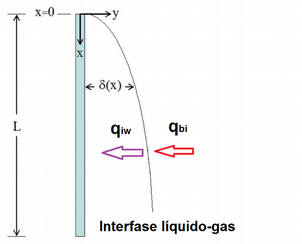

El calor que se transfiere por la película de condensado es debido a conducción, mientras que el que va de los gases a la interfase tiene una componente convectiva y otra de condensación ligada a la transferencia de masa,



## Flux de calor a través de la película de condensado

<p>&nbsp;</p>
Para hallar el flux de calor a través de la película de líquido, usamos la expresión de nusselt modificada por Herranz et al.: 

$$ q_{iw}= \left(\frac{ρ_l(ρ_l-ρ_{gb})gh^{'}_{fg}k^{3}_{l}}{4\mu_lz(T_i-T_w)}\right)^{1/4}\Psi(T_i-T_w) $$

Donde $\Psi$ corresponde al factor de corrección de Kutatelatze et al dado por:   $ \Psi= Re^{0.004} $

A partir de este flux calculamos el coeficiente de transferencia de calor en la película $h_{film}$


In [5]:

h_fgcorr= h_fg_prom*(1+(0.68*(cp_cond*(T_i-T_w)/h_fg_prom))) # Entalpía de vaporización corregida, Ecuacion 3 Herranz 1998
psi=re_l**0.004 # Factor de corrección Kutateladze, Herranz 

#Calor transferido por la interfase, de la película a la superficie [W/m²]
q_iw=((den_cond*(den_cond-den_gases)*g*h_fgcorr*(k_cond**3)/(4*visc_cond*Lc*(T_i-T_w)))**(1/4))*psi*(T_i-T_w)

#Coeficiente de transferencia de película [W/m²K]
h_film=q_iw/(T_i-T_w)

print("Flux de calor q_iw:", round(q_iw,2), "W/m²")
print("h_film:", round(h_film,2), "W/m²K")


Flux de calor q_iw: 343.56 W/m²
h_film: 6871.25 W/m²K


## Flux de calor de mezcla de gases

Este modelo asume como despreciable el aporte de la radiación de los gases a la transferencia de calor, reduciéndola exclusivamente a componentes convectivas y de condensación:

$$ q_{ib}= (h_{conv}+h_{cond})(T_b-T_i) $$

Inicialmente, se halla el coeficiente h por conveccción. Luego se halla el de condensación, que requiere cálculo de difusividad entre las especies y del uso de la analogía de transferencia de calor/masa.


### Coeficiente de transferencia de calor por convección

<p style='text-align: justify;'>En el modelo propuesto por Herranz et al, para el cálculo del h convectivo se utiliza la correlación de Mc Adams para convección natural turbulenta, debido a que el modelo simula las condiciones de accidente en un reactor nuclear. En el caso del sistema de condensación de gases de pirólisis, se tienen condiciones de convección forzada en flujo interno, por lo que se modificará el modelo usando una correlación correspondiente a esas características para la geometría deseada. 
</p>

Este modelo selecciona automáticamente la correlación dependiendo del número de Reynolds calculado:



   Flujo interno laminar en desarrollo, región de entrada térmica con T de pared constante:
   
 $\hspace{1.5cm} Re\leq 3000 \hspace{3cm} \overline{Nu_x}= 3.66+\frac{0.065(D/L)RePr}{1+0.04[(D/L)RePr]^{2/3}}$
 
 Correlación de Gnielinski para flujo en desarrollo convección forzada flujo interno:
 
$\hspace{1cm}  3000 \leq Re \leq 10000\hspace{2cm} \overline{Nu_x}= \frac{(f/8)(Re-1000)Pr}{1.07 + 12.7(f/8)^{0.5} (Pr^{2/3}-1)}  $ 

Correlación de Gnielinski para flujo turbulento convección forzada flujo interno (factor de fricción modificado mediante ecuación de Pethukov)
 
$\hspace{1cm}  10000 \leq Re \leq 5(10^6)\hspace{2cm} \overline{Nu_x}= \frac{(f^*/8)(Re-1000)Pr}{1.07 + 12.7(f^*/8)^{0.5} (Pr^{2/3}-1)}  $ 


In [6]:
if re_g <3000:
    #factor de fricción para tubo liso en regimen de transición para convección forzada - cengel 8-74
    f=(3.03*(10**-12)*(re_g**3))-(3.67*(10**-8)*(re_g**2))+(1.46*(10**-4)*re_g)-0.151 
    
    #Cengel 8-62 - Edwards 1979, Nusselt promedio para flujo en desarrollo en la entrada
    h_conv= (3.66+((0.065*(d_ti/Z)*re_g*Pr_gas)/(1+0.04*(d_ti*re_g*Pr_gas/Z)**(2/3))))*k_gas/Lc
         
else:
    
    #Gnielinski, flujo en desarrollo convección forzada flujo interno(3000<Re<10000) - Cengel 8-71
    f=(0.790*math.log(re_g)-1.64)**(-2) #Primera ecuación de Pethukov Cengel 8-65
    h_conv=(f/8)*(re_g-1000)*Pr_gas/(1+12.7*((f/8)**0.5)*(Pr_gas**(2/3)-1))*(k_gas/Lc) 
    

print("h_conv: {} W/m²K".format(round(h_conv,2)))


h_conv: 3.58 W/m²K


### Coeficiente de transferencia por difusión

Inicialmente, se calcula el coeficiente de difusión del vapor en el gas no condensable, utilizando la teoría de Chapman-Enskog [2] para el cálculo de coeficientes binarios de difusión para el caso de sistemas a baja presión :

$$ D_{a,b}= \frac{0.00266T^{3/2}}{PM_{AB}^{1/2}\sigma^2_{AB}\Omega_D}$$

Donde la integral de colisión omega se calcula con

$$ \Omega_D= \frac{A}{(T^*)^B}+\frac{C}{exp(DT^*)}+  \frac{E}{exp(FT^*)}+ \frac{G}{exp(HT^*)}\\ $$ Donde $$ T^*=\kappa T/\epsilon_{AB}$$

Siendo A,B,C,D,E,F,G,H constantes. Con este coeficiente de difusión, se calcula el número de Schmidt. Posteriormente, aplicando la analogía de transferencia de calor y masa, se calcula el número de Sherwood.

#### Efecto de succión

En los sistemas de condensación, la absorción de vapor en la capa líquida crea un encogimiento de la capa límite que incrementa los fenómenos de transferencia. Este fenómeno se llama "factor de succión" y su importancia ha sido demostrada por varios autores en diferentes geometrías (Lienhard y Dhir, 1972; Aggarwal y Hollingsworth, 1973; Yeroshenko et al., 1984; Kays and Crawford,1993.)

$$ \Theta=\frac{X_{nc}^{i}}{X_{nc}^{avg}}$$

Donde $X_{nc}$ es la fracción molar de no condensables promedio y en la interfase para avg e i respectivamente. 



In [7]:
diff_params=difusion(comp, gases, P, T_g, Frac_n2, frac_comp, masa_total)
D_global= diff_params[0]['Nitrogen']
df= diff_params[1]


M_red_vap = diff_params[2]


In [8]:
R_gases=8.31442 # Constante universal de los gases J/K mol
phi=(moles_cond/(moles_N2+moles_cond))/(moles_N2/(moles_N2+moles_cond))
theta=(moles_N2/(moles_N2+moles_cond))/(moles_N2_bulk/(moles_cond_bulk+moles_N2_bulk))
Sc=visc_gases/(den_gases*D_global)# Número de Schmidt


if re_g<3000:
  
    #Cengel 14-78 - Analogía transferencia de masas: Sherwood es la misma expresión que Nusselt,
        # cambiando Prandtl por schmidt
        #factor de fricción para tubo liso en regimen de transición para convección forzada - cengel 8-74
    f=(3.03*(10**-12)*(re_g**3))-(3.67*(10**-8)*(re_g**2))+(1.46*(10**-4)*re_g)-0.151 
    
        #Cengel 8-62 - Edwards 1979, Nusselt promedio para flujo en desarrollo en la entrada
    Sh_0= (3.66+((0.065*(d_ti/Z)*re_g*Sc)/(1+0.04*(d_ti*re_g*Sc/Z)**(2/3))))
       
    
else:
     
    #Gnielinski, flujo en desarrollo convección forzada flujo interno(3000<Re<10000) - Cengel 8-71
    f=(0.790*math.log(re_g)-1.64)**(-2) #Primera ecuación de Pethukov Cengel 8-65
    Sh_0=(f/8)*(re_g-1000)*Sc/(1+12.7*((f/8)**0.5)*(Sc**(2/3)-1))



Sh=Sh_0*theta #Sherwood corregido por succión
delta=Lc/Sh
print("D_global:", D_global, "m²/s")

print("Sc:", round(Sc,6))
print("Sh:", Sh)
print("Theta:", round(theta,2))
print("Delta:", round(delta,6))



D_global: 6.951470766388556e-06 m²/s
Sc: 1.335058
Sh: 13.456150859480498
Theta: 1.0
Delta: 0.005791


### Coeficiente de transferencia por condensación

<p style='text-align: justify;'>Para el flux de calor por condensación, se usa el planteamiento hecho por Peterson et al (1992), apoyado en la ecuación de Clapeyron para expresar dependencias de presión y concentración en términos de temperatura. Así, el coeficiente de transferencia de calor puede escribirse en términos de un parámetro llamado conductividad de condensación,la conductividad térmica de la mezcla gaseosa y los números de Sherwood y Prandtl:
</p>
<p>&nbsp;</p>

$$ q_{bi}=\frac{Sh}{L}k_{eff}(T_b-T_i)=(h_{cond}+h_{conv})(T_b-T_i)\\ k_{eff}=k_{cond}+\left(\frac{Pr}{Sc}\right)^{1/3}k_g \\ k_{cond}= \left(\frac{CM_vh^{2}_{fg} D_{a,b}}{R_vT_iT_b}\right)\Phi\\h_{cond}=\frac{Sh_o}{L}k_{cond}$$


<p>&nbsp;</p>
Donde $\Phi$ es la relación entre las fracciones molares promedio del vapor y los no condensables en la capa límite.

In [9]:
cond_cond=((conc_b*(M_red_vap/1000)*(h_fgcorr**2)*D_global)/(R_gases*T_i*T_g))*phi #[W/mK] Herranz Concentración en kg/m³

k_eff=cond_cond+((Pr_gas/Sc)**(1/3))*k_gas
q_bi1=Sh*k_eff*(T_g-T_i)/Lc
h_cond=Sh*cond_cond/Lc
q_bi2=(h_cond+h_conv)*(T_g-T_i)

diff=q_bi2-q_iw

print("cond_cond:", cond_cond)
print("Keff:", k_eff)
print("Flux de calor q_bi1:", round(q_bi1,2), "W/m²")
print("Flux de calor q_bi:", round(q_bi2,2), "W/m²")
print("h_condensación:", round(h_cond,5), "W/m²K")


cond_cond: 0.0035960978231039265
Keff: 0.02456861446524384
Flux de calor q_bi1: 533.74 W/m²
Flux de calor q_bi: 527.98 W/m²
h_condensación: 0.62102 W/m²K


### Cierre del balance

Finalmente, se itera $T_i$ hasta que los flux de calor sean iguales. En ese valor de los calores se calcula $h_{total}$, de acuerdo a la siguiente ecuación:

$$ q_{bw}= h_{T}(T_b-T_i)= \left(\frac{h_{film}(h_{conv}+h_{cond})}{h_{film}+h_{conv}+h_{cond}}\right)(T_b-T_i)$$



In [10]:
h_tot=(h_film*(h_conv+h_cond))/(h_film+h_conv+h_cond)


print("q_bi: {} W/m²".format(round(q_bi2,2)),
      "q_iw: {} W/m²".format(round(q_iw,2)),
      "h_film: {} W/m²".format(round(h_film,2)),
      "h_conv: {} W/m²K".format(round(h_conv,2)),
      "h_cond: {} W/m²K".format(round(h_cond,2)),
      "Diff: {} W/m²K".format(round(diff,2)),
      "\n",
      "h_total: {} W/m²K".format(round(h_tot,2)),
      sep='\n')


q_bi: 527.98 W/m²
q_iw: 343.56 W/m²
h_film: 6871.25 W/m²
h_conv: 3.58 W/m²K
h_cond: 0.62 W/m²K
Diff: 184.41 W/m²K


h_total: 4.19 W/m²K



### Cálculo del área de transferencia de calor&nbsp;


Finalmente, para el cálculo del área requerida para la transferencia de calor, se aplica la ecuación para el caso específico de temperatura de pared constante en un tubo, que será un parámetro de diseño:

$$Q_{req} = hA_s \Delta T_{lm}$$

donde $T_{lm}$ es la temperatura media logarítmica:

$$\Delta T_{lm}= \frac{T_{ent}-T_{sal}}{ln\left( \frac{T_w-T_{sal}}{T_w-T_{ent}}\right)}$$


Dado que tomamos la temperatura de salida como condición de diseño, tenemos finalmente el área requerida:


$$  A_s =\frac{Q_{req}}{h\Delta T_{lm}}$$


In [11]:
AREA2=Q_req/(h_tot*((T_g-T_sal)/np.log((T_g-T_sal)/(T_sal-T_w)))) #8-30 Cengel

print("Área requerida para el intercambiador:", round(AREA2,4), "m²")

Área requerida para el intercambiador: 2.5746 m²


In [12]:
a_tubo = math.pi*d_ti*Z

a_placas = d_ti*Z*2+ 0.075*Z*2*2+ 0.067*Z*2*2+ 0.04*Z*2

print("Área interna del tubo de",Z," m :", round(a_tubo,4),  "m²")

print("Área de placas [m] :", round(a_placas,4), "m²")

print("Área de tubo + placa [m] :", round( a_tubo+ a_placas ,4), "m²")




Área interna del tubo de 2.5  m : 0.612 m²
Área de placas [m] : 2.0096 m²
Área de tubo + placa [m] : 2.6216 m²


Condensador @ 80 °C = 3.86 W/m2K long 2  m    Gotas = 81  W/m2K A_req = 1.55 m2   21 veces


Condensador @ 0 °C = 4.19  W/m2K long 2.5 m     Gotas = 103 W/m2K A_req = 2.57      25 veces

### Referencias&nbsp;

[1]<a href="https://www.sciencedirect.com/science/article/pii/S0029549398001642"> <i> Herranz et al. 1998 -A diffusion layer model for steam condensation within the AP600 containment, Nuclear engineering and design </i></a> 

